In [1]:
import os
import sys

MAIN_PATH = os.path.dirname(os.getcwd())
sys.path.insert(0, MAIN_PATH)

import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import maximum_filter
import librosa.display

In [2]:
dejavu_path = os.path.join(MAIN_PATH, 'dejavu_fingerprinting')
sys.path.insert(0, dejavu_path)

In [3]:
from dejavu.logic.recognizer.file_recognizer import FileRecognizer
from dejavu import Dejavu
from audiomentations import AddBackgroundNoise

In [4]:
config = {
    "database": {
        "host": "127.0.0.1",
        "user": "root",
        "password": "mysqlpass",
        "database": "dejavu",
    }
}
djv = Dejavu(config)

In [5]:
noise_path = os.path.join(MAIN_PATH, 'data/background_test/Cafe In Paris - QuickSounds.com.wav')

In [6]:
target = 'data/small_dataset/demo_songs/The Weeknd - Blinding Lights.wav'

y, sr = librosa.load(
    os.path.join(MAIN_PATH, target),
    sr=8000,
    offset=60,
    duration=10
)

In [7]:
import soundfile as sf

In [8]:
snrs = np.arange(start=-5, stop=15, step=0.5)
scores = []
temp_noise_path = os.path.join(dejavu_path, 'temp_noise.wav')
results = []

for snr in snrs:
    b_noise = AddBackgroundNoise(sounds_path=noise_path, max_snr_db=snr, min_snr_db=snr, p=1.)
    y_noise = b_noise(y, sample_rate=sr)
    y_noise /= y_noise.max()
    y_noise *= 2**15
    y_noise = y_noise.astype(np.int16)
    sf.write(file=temp_noise_path, data=y_noise, samplerate=sr, subtype='PCM_16')
    d = djv.recognize(FileRecognizer, temp_noise_path)
    pred = d["results"][0]["song_name"].decode()
    score = d["results"][0]["input_confidence"]
    
    results.append((snr, pred, score))
    

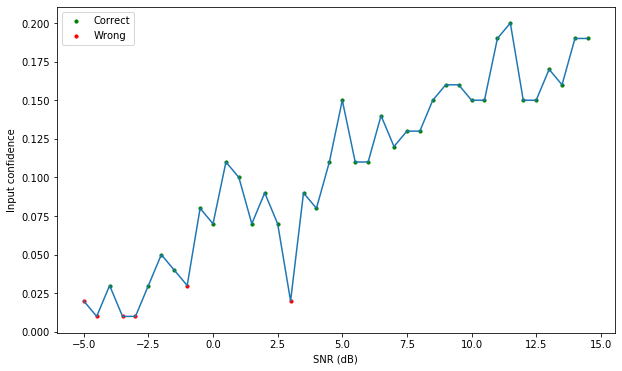

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
snrs, scores = [], []
snrs_true, scores_true = [], []
snrs_false, scores_wrong = [], []

for snr, pred, score in results:
    snrs.append(snr)
    scores.append(score)
    if pred == os.path.basename(target)[:-4]:
        snrs_true.append(snr)
        scores_true.append(score)
    else:
        snrs_false.append(snr)
        scores_wrong.append(score)

ax.plot(snrs, scores)
ax.scatter(snrs_true, scores_true, color='green', label='Correct', s=10)
ax.scatter(snrs_false, scores_wrong, color='red', label='Wrong', s=10)
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Input confidence')

plt.legend()
plt.savefig(os.path.join(MAIN_PATH, 'images/dejavu_confidence_snr.pdf'), format='pdf')
plt.show()